### Import Dataset for Process mining

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/major_project/Insurance_claims_event_log.csv"

event_log = pd.read_csv(file_path)
print(event_log.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   case_id           180000 non-null  object 
 1   activity_name     180000 non-null  object 
 2   timestamp         180000 non-null  object 
 3   claimant_name     180000 non-null  object 
 4   agent_name        180000 non-null  object 
 5   adjuster_name     180000 non-null  object 
 6   claim_amount      180000 non-null  float64
 7   claimant_age      180000 non-null  int64  
 8   type_of_policy    180000 non-null  object 
 9   car_make          180000 non-null  object 
 10  car_model         180000 non-null  object 
 11  car_year          180000 non-null  int64  
 12  type_of_accident  180000 non-null  object 
 13  user_type         180000 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 19.2+ MB
None


Timestamp Verification and Conversion

In [ ]:
print(event_log['timestamp'].isnull().sum())
event_log['timestamp'] = pd.to_datetime(event_log['timestamp'], errors='coerce')
event_log = event_log.dropna(subset=['timestamp'])

print(event_log['timestamp'].head())

0
0   2020-09-24 14:08:42.423530
1   2020-10-13 03:51:28.627923
2   2020-10-14 22:30:14.948970
3   2020-10-24 11:49:39.053890
4   2020-10-27 05:46:04.378718
Name: timestamp, dtype: datetime64[ns]


Duplicate Check

In [ ]:
duplicates = event_log.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

event_log = event_log.drop_duplicates()
print(event_log.duplicated().sum())

Number of duplicate rows: 0
0


Sort by case_id and timestamp

In [ ]:
# Sort by case_id and timestamp
event_log = event_log.sort_values(by=['case_id', 'timestamp'])

## Ensureing Required Columns Are Present for Process Mining
For process mining, the essential columns are:

- case_id (identifies a unique process instance).
- activity_name (the event or activity in the process).
- timestamp (when the activity occurred).

In [ ]:
pm_log = event_log[['case_id', 'activity_name', 'timestamp']]
print(pm_log.info())

<class 'pandas.core.frame.DataFrame'>
Index: 180000 entries, 75954 to 178187
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   case_id        180000 non-null  object        
 1   activity_name  180000 non-null  object        
 2   timestamp      180000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 5.5+ MB
None


## Appling Process Mining

1. Convert the Event Log for Process Mining

In [ ]:
!pip install pm4py

In [ ]:
import pm4py
from pm4py.objects.conversion.log import converter as log_converter

pm_log = pm_log.rename(columns={
    "case_id": "case:concept:name",
    "activity_name": "concept:name",
    "timestamp": "time:timestamp"
})

# Convert the DataFrame to an Event Log object
log = log_converter.apply(pm_log, parameters={
    "case_id_key": "case:concept:name",
    "activity_key": "concept:name",
    "timestamp_key": "time:timestamp"
})


# Check the log to ensure it's converted properly
print(f"Number of cases: {len(log)}")

Number of cases: 30000


2. Discover the Process Model

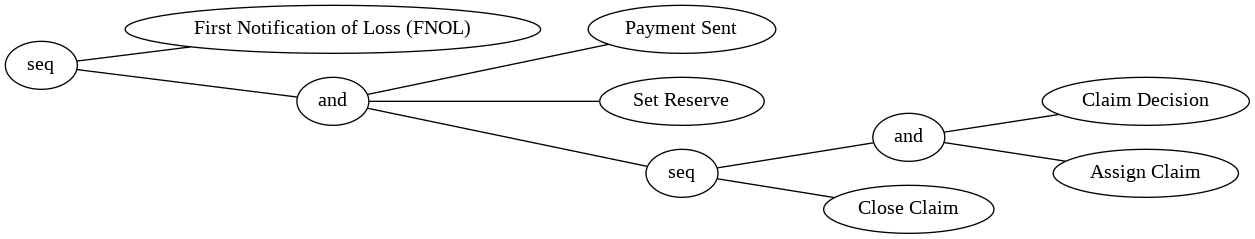

In [ ]:
from pm4py.visualization.process_tree import visualizer as pt_visualizer

# Apply the Inductive Miner algorithm to discover a process tree
process_tree = pm4py.discover_process_tree_inductive(log)

# Visualize the process tree
gviz = pt_visualizer.apply(process_tree)
pt_visualizer.view(gviz)

3. Analyze Process Statistics

In [ ]:
from pm4py.statistics.traces.generic.log import case_statistics as case_stats

print(dir(case_stats))

['Any', 'BusinessHours', 'DEFAULT_TIMESTAMP_KEY', 'DEFAULT_TRACEID_KEY', 'Dict', 'Enum', 'EventLog', 'List', 'Optional', 'Parameters', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'case_duration_commons', 'constants', 'exec_utils', 'get_all_case_durations', 'get_cases_description', 'get_events', 'get_first_quartile_case_duration', 'get_kde_caseduration', 'get_kde_caseduration_json', 'get_median_case_duration', 'get_variant_statistics', 'index_log_caseid', 'log_converter', 'np', 'variants_get']


In [ ]:
from pm4py.statistics.traces.generic.log import case_statistics as case_stats

# Case duration statistics
case_durations = case_stats.get_all_case_durations(log, parameters={"timestamp_key": "timestamp"})
print(f"Average case duration: {sum(case_durations) / len(case_durations)} seconds")

# Get variant statistics instead of get_most_common_traces
variant_statistics = case_stats.get_variant_statistics(log, parameters={"timestamp_key": "timestamp"})
sorted_variants = sorted(variant_statistics, key=lambda x: x['count'], reverse=True)

print("Most frequent traces:")
for variant in sorted_variants[:5]:  # Top 5 traces
    print(f"Variant: {variant['variant']}, Count: {variant['count']}")

Average case duration: 3025321.3684709542 seconds
Most frequent traces:
Variant: ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Set Reserve', 'Payment Sent', 'Close Claim'), Count: 29265
Variant: ('First Notification of Loss (FNOL)', 'Claim Decision', 'Assign Claim', 'Set Reserve', 'Payment Sent', 'Close Claim'), Count: 188
Variant: ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Payment Sent', 'Set Reserve', 'Close Claim'), Count: 180
Variant: ('First Notification of Loss (FNOL)', 'Assign Claim', 'Set Reserve', 'Claim Decision', 'Payment Sent', 'Close Claim'), Count: 175
Variant: ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Set Reserve', 'Close Claim', 'Payment Sent'), Count: 173


#  Hugging Face Transformers (LLM Integration Framework)

1. Define the Process Insights

In [ ]:
process_insights = {
    "average_case_duration": "3025321.37 seconds",
    "frequent_traces": [
        {"variant": ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Set Reserve', 'Payment Sent', 'Close Claim'), "count": 29265},
        {"variant": ('First Notification of Loss (FNOL)', 'Claim Decision', 'Assign Claim', 'Set Reserve', 'Payment Sent', 'Close Claim'), "count": 188},
        {"variant": ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Payment Sent', 'Set Reserve', 'Close Claim'), "count": 180},
        {"variant": ('First Notification of Loss (FNOL)', 'Assign Claim', 'Set Reserve', 'Claim Decision', 'Payment Sent', 'Close Claim'), "count": 175},
        {"variant": ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Set Reserve', 'Close Claim', 'Payment Sent'), "count": 173},
    ],
}

2. Write the Prompt for the LLM

In [ ]:
def create_prompt_with_insights(question, insights):
    prompt = f"""
The following are process insights for handling insurance claims:
1. Average case duration: {insights['average_case_duration']}
2. Most frequent traces:
"""
    for trace in insights["frequent_traces"]:
        prompt += f"    - Trace: {trace['variant']}, Count: {trace['count']}\n"

    prompt += f"""
Question: {question}
Answer:
"""
    return prompt

In [ ]:
def create_prompt_without_insights(question):
    prompt = f"""
The following process represents the handling of insurance claims:
['First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Set Reserve', 'Payment Sent', 'Close Claim']

Question: {question}
Answer:
"""
    return prompt

3. Query the LLM

In [ ]:
from transformers import pipeline

# Load the LLM
generator = pipeline("text-generation", model="EleutherAI/gpt-neo-1.3B")

# Query with process insights
def answer_with_insights(question, insights):
    prompt = create_prompt_with_insights(question, insights)
    response = generator(prompt, max_length=2000, num_return_sequences=1)
    return response[0]["generated_text"]

# Query without process insights
def answer_without_insights(question):
    prompt = create_prompt_without_insights(question)
    response = generator(prompt, max_length=2000, num_return_sequences=1)
    return response[0]["generated_text"]

Device set to use cpu


In [ ]:
question = "What is the most frequent sequence of activities in the process?"

# Answer with process insights
print("Answer with Process Insights:")
print(answer_with_insights(question, process_insights))

# Answer without process insights
print("\nAnswer without Process Insights:")
print(answer_without_insights(question))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer with Process Insights:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



The following are process insights for handling insurance claims:
1. Average case duration: 3025321.37 seconds
2. Most frequent traces:
    - Trace: ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Set Reserve', 'Payment Sent', 'Close Claim'), Count: 29265
    - Trace: ('First Notification of Loss (FNOL)', 'Claim Decision', 'Assign Claim', 'Set Reserve', 'Payment Sent', 'Close Claim'), Count: 188
    - Trace: ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Payment Sent', 'Set Reserve', 'Close Claim'), Count: 180
    - Trace: ('First Notification of Loss (FNOL)', 'Assign Claim', 'Set Reserve', 'Claim Decision', 'Payment Sent', 'Close Claim'), Count: 175
    - Trace: ('First Notification of Loss (FNOL)', 'Assign Claim', 'Claim Decision', 'Set Reserve', 'Close Claim', 'Payment Sent'), Count: 173

Question: What is the most frequent sequence of activities in the process?
Answer:
1. First notification of loss (FNOL) 
                        